In [62]:
%load_ext pycodestyle_magic

In [63]:
%pycodestyle_on

# Predictive Modelling for Salary Estimation

The goal of this project is to build Machine Learning models that produce salary range estimates for jobs in the field of Software Engineering and Computer science based on current job offers found on the popular job board site [Indeed](https://ca.indeed.com/). 

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

# 1. Web Scraping Job Postings from Indeed: 

In order to build my dataset, I needed to collect several thousands of job ads. To do so, I used the Indeed Scraper from [APIFY](https://apify.com/hynekhruska/indeed-scraper). Although I successfully built a web scraper of my own, the website would block it after collecting around 900 job ads. To circumvent this issue, and since I needed to collect a larger number of data points, I utilized Apify's pre-built Indeed scraper. 

Using keywords "software engineering" and "computer science" as job field entries and "montreal qc", "toronto on" and "vancouver bc" for the location field, I collected job offers for Canada's top 3 tech cities. The result was 6 csv files with columns = { "positionName", "company", "location", "rating", "reviewsCount", "url", "id", "postedAt", "scrapedAt", "description" }

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

# 2. Dataset Preparation: 

Now that we have acquired our content, we proceed to enrichment with the goal of building a dataset fit for our machine learning models. This is an iterative process involving data exploration, cleaning, and feature engineering. 

In [64]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

<div style="border-bottom: 3px solid black;"></div>

### Task 2.1 &mdash; Load scraped datasets and combine into a single Pandas DataFrame

In [66]:
# read csv files containing scraped data for
# cities = {Montreal, Toronto, Vancouver}
mtl_soen_data = pd.read_csv("soen_mtl.csv")
mtl_comp_data = pd.read_csv("compsci_mtl.csv")
to_soen_data = pd.read_csv("soen_to.csv")
to_comp_data = pd.read_csv("compsci_to.csv")
van_soen_data = pd.read_csv("soen_van.csv")
van_comp_data = pd.read_csv("compsci_van.csv")

In [67]:
# create a joint dataset for the scraped data
joint_data = pd.concat([mtl_soen_data,
                        mtl_comp_data,
                        to_soen_data,
                        to_comp_data,
                        van_soen_data,
                        van_comp_data], axis=0)

In [68]:
# check shape
joint_data.shape

(5986, 11)

In [69]:
# Print the first 5 rows of the dataset
joint_data.head()

,company,description,id,location,positionName,postedAt,rating,reviewsCount,salary,scrapedAt,url
0,Scrawlr Development Inc.,About ScrawlrScrawlr is a company building a s...,7caf9dd0cb72ecff,"Montréal, QC",Intermediate Front-End Software Developer,Just posted,NaN,NaN,"$72,000 - $89,000 a year",2022-04-05T19:38:07.461Z,https://www.indeed.ca/company/Virtus-Services-...
1,Joseph Ribkoff,Joseph Ribkoff designs classic and contemporar...,5a58d7dbc41ea8c6,"Saint-Laurent, QC",Dynamics 365 Developer,Just posted,3.5,23.0,NaN,2022-04-05T19:38:08.732Z,https://www.indeed.ca/rc/clk?jk=5a58d7dbc41ea8...
2,TELUS International,Full Stack Developer (React.js & Node.js)Descr...,b2e0c233222a2f9e,Canada,Full Stack Developer (React.js & Node.js),Just posted,NaN,NaN,$55 - $60 an hour,2022-04-05T19:38:12.450Z,https://www.indeed.ca/pagead/clk?mo=r&ad=-6NYl...
3,SAP,What we offer\nOur company culture is focused ...,40f439836db66616,"Montréal, QC",SAP iXp Intern - Frontend Developer,Just posted,4.3,2622.0,NaN,2022-04-05T19:38:12.147Z,https://www.indeed.ca/rc/clk?jk=40f439836db666...
4,Scrawlr Development Inc.,About ScrawlrScrawlr is a company building a s...,0f011f6b4930681a,"Montréal, QC",Senior Front-End Software Developer,Just posted,NaN,NaN,"$85,000 - $110,000 a year",2022-04-05T19:38:13.750Z,https://www.indeed.ca/company/Virtus-Services-...


<div style="border-bottom: 3px solid black;"></div>

### Task 2.2 &mdash; Remove all job ads with undisclosed salary offer

Out of the 5986 jobs scraped from Indeed, the only ones I can use in this project are the ones that disclose salary. I therefore need to eliminate all rows for which the value in the salary column in NaN.

In [70]:
def salary_notna(df):
    """
    This function returns a new DataFrame by removing
    all jobs with no salary info.
    J. Bazarbachian
    Input
    ---------
    df : pandas DataFrame
        DataFrame containing scraped job data
    Output
    ---------
    df : pandas DataFrame
        New DataFrame with NaN salary value jobs removed
    Example
    -------
    >>> valid_data = salary_notna(joint_data)
    >>> print('Current dataset size: %d jobs' % len(valid_data))
    Current dataset size: 973 jobs
    """
    return df[df['salary'].notna()]


valid_data = salary_notna(joint_data)
print('Current dataset size: %d jobs' % len(valid_data))
valid_data.head()

,company,description,id,location,positionName,postedAt,rating,reviewsCount,salary,scrapedAt,url
0,Scrawlr Development Inc.,About ScrawlrScrawlr is a company building a s...,7caf9dd0cb72ecff,"Montréal, QC",Intermediate Front-End Software Developer,Just posted,NaN,NaN,"$72,000 - $89,000 a year",2022-04-05T19:38:07.461Z,https://www.indeed.ca/company/Virtus-Services-...
2,TELUS International,Full Stack Developer (React.js & Node.js)Descr...,b2e0c233222a2f9e,Canada,Full Stack Developer (React.js & Node.js),Just posted,NaN,NaN,$55 - $60 an hour,2022-04-05T19:38:12.450Z,https://www.indeed.ca/pagead/clk?mo=r&ad=-6NYl...
4,Scrawlr Development Inc.,About ScrawlrScrawlr is a company building a s...,0f011f6b4930681a,"Montréal, QC",Senior Front-End Software Developer,Just posted,NaN,NaN,"$85,000 - $110,000 a year",2022-04-05T19:38:13.750Z,https://www.indeed.ca/company/Virtus-Services-...
6,LearningBranch Inc.,Job Title: Senior Machine Learning EngineerSta...,f0350e40e06d39c7,"Montréal, QC",Senior Machine Learning Engineer,Just posted,NaN,NaN,"$65,000 - $120,000 a year",2022-04-05T19:38:16.469Z,https://www.indeed.ca/company/LearningBranch-I...
7,Scrawlr Development Inc.,About ScrawlrScrawlr is a company building a s...,8109b9b51e80a7aa,"Montréal, QC",Lead Front-End Software Developer,Just posted,NaN,NaN,"$87,000 - $120,000 a year",2022-04-05T19:38:17.143Z,https://www.indeed.ca/company/Virtus-Services-...


<div style="border-bottom: 3px solid black;"></div>

### Task 2.3 &mdash; Remove duplicate job ads

Using the *id* column, remove duplicate jobs

In [71]:
def remove_duplicates(df):
    """
    This function create new DataFrame with no duplicate jobs.
    J. Bazarbachian
    Input
    ---------
    df : pandas DataFrame
        DataFrame containing scraped job data
    Output
    ---------
    df : pandas DataFrame
        New DataFrame with no duplicate jobs
    Example
    -------
    >>> data_no_duplicates = remove_duplicates(valid_data)
    >>> print('Current dataset size: %d jobs' % len(data_no_duplicates))
    Current dataset size: 835 jobs
    """
    return df.drop_duplicates(subset="id")


data_no_duplicates = remove_duplicates(valid_data)
print('Current dataset size: %d jobs' % len(data_no_duplicates))
data_no_duplicates.head()

,company,description,id,location,positionName,postedAt,rating,reviewsCount,salary,scrapedAt,url
0,Scrawlr Development Inc.,About ScrawlrScrawlr is a company building a s...,7caf9dd0cb72ecff,"Montréal, QC",Intermediate Front-End Software Developer,Just posted,NaN,NaN,"$72,000 - $89,000 a year",2022-04-05T19:38:07.461Z,https://www.indeed.ca/company/Virtus-Services-...
2,TELUS International,Full Stack Developer (React.js & Node.js)Descr...,b2e0c233222a2f9e,Canada,Full Stack Developer (React.js & Node.js),Just posted,NaN,NaN,$55 - $60 an hour,2022-04-05T19:38:12.450Z,https://www.indeed.ca/pagead/clk?mo=r&ad=-6NYl...
4,Scrawlr Development Inc.,About ScrawlrScrawlr is a company building a s...,0f011f6b4930681a,"Montréal, QC",Senior Front-End Software Developer,Just posted,NaN,NaN,"$85,000 - $110,000 a year",2022-04-05T19:38:13.750Z,https://www.indeed.ca/company/Virtus-Services-...
6,LearningBranch Inc.,Job Title: Senior Machine Learning EngineerSta...,f0350e40e06d39c7,"Montréal, QC",Senior Machine Learning Engineer,Just posted,NaN,NaN,"$65,000 - $120,000 a year",2022-04-05T19:38:16.469Z,https://www.indeed.ca/company/LearningBranch-I...
7,Scrawlr Development Inc.,About ScrawlrScrawlr is a company building a s...,8109b9b51e80a7aa,"Montréal, QC",Lead Front-End Software Developer,Just posted,NaN,NaN,"$87,000 - $120,000 a year",2022-04-05T19:38:17.143Z,https://www.indeed.ca/company/Virtus-Services-...


<div style="border-bottom: 3px solid black;"></div>

### Task 2.4 &mdash; Create a new DataFrame with relevant features
 
The new DataFrame has columns ['company', 'positionName', 'location', 'salary', 'description']

In [72]:
def drop_unused_columns(df):
    """
    This function create new DataFrame with selected columns.
    J. Bazarbachian
    Input
    ---------
    df : pandas DataFrame
        DataFrame containing scraped job data
    Output
    ---------
    df : pandas DataFrame
        New DataFrame with columns ['company', 'positionName',
        'location', 'salary', 'description']
    Example
    -------
    >>> reshaped_data = drop_unused_columns(data_no_duplicates)
    >>> print('Current dataset size: %d jobs' % len(reshaped_data))
    Current dataset size: 835 jobs
    """
    return df[['company', 'positionName',
               'location', 'salary', 'description']].reset_index(drop=True)


reshaped_data = drop_unused_columns(data_no_duplicates)
print('Current dataset size: %d jobs' % len(reshaped_data))
reshaped_data.head()

,company,positionName,location,salary,description
0,Scrawlr Development Inc.,Intermediate Front-End Software Developer,"Montréal, QC","$72,000 - $89,000 a year",About ScrawlrScrawlr is a company building a s...
1,TELUS International,Full Stack Developer (React.js & Node.js),Canada,$55 - $60 an hour,Full Stack Developer (React.js & Node.js)Descr...
2,Scrawlr Development Inc.,Senior Front-End Software Developer,"Montréal, QC","$85,000 - $110,000 a year",About ScrawlrScrawlr is a company building a s...
3,LearningBranch Inc.,Senior Machine Learning Engineer,"Montréal, QC","$65,000 - $120,000 a year",Job Title: Senior Machine Learning EngineerSta...
4,Scrawlr Development Inc.,Lead Front-End Software Developer,"Montréal, QC","$87,000 - $120,000 a year",About ScrawlrScrawlr is a company building a s...


<div style="border-bottom: 3px solid black;"></div>

### Task 2.5 &mdash; Explore data

From the 5986 jobs that were originally scraped from Indeed, we now are left with 835. As a result, only 13.9% of job advertisements included any information on expected pay.

In [73]:
reshaped_data['company'].describe()

count                          835
unique                         503
top       Scrawlr Development Inc.
freq                            42
Name: company, dtype: object

In [74]:
reshaped_data['positionName'].describe()

count                      835
unique                     632
top       Full Stack Developer
freq                        13
Name: positionName, dtype: object

In [75]:
reshaped_data['location'].describe()

count             835
unique             46
top       Toronto, ON
freq              221
Name: location, dtype: object

In [76]:
reshaped_data['salary'].describe()

count                835
unique               455
top       $80,000 a year
freq                  26
Name: salary, dtype: object

In [77]:
salary = reshaped_data['salary']
salary[0:20]

0       $72,000 - $89,000 a year
1              $55 - $60 an hour
2      $85,000 - $110,000 a year
3      $65,000 - $120,000 a year
4      $87,000 - $120,000 a year
5      $85,000 - $145,000 a year
6                 $95,000 a year
7      $75,000 - $140,000 a year
8              $40 - $65 an hour
9      $80,973 - $150,558 a year
10                $60,000 a year
11                $90,000 a year
12    $115,000 - $125,000 a year
13                $50,000 a year
14                $98,900 a year
15     $85,000 - $100,000 a year
16      $53,291 - $86,609 a year
17     $65,000 - $115,000 a year
18     $80,000 - $150,000 a year
19                $23.59 an hour
Name: salary, dtype: object

In [78]:
description = reshaped_data['description']
description[2]

"About ScrawlrScrawlr is a company building a software platform and series of products dedicated to enabling alternative forms of communication layered on existing internet content, together with delivering superior monetization flexibility and content ownership for content generators. We have recently completed our internal beta and are preparing for our external beta. We are looking forward to bringing on additional like-minded individuals to assist in product launch. The founder, board of directors, and lead investors in Scrawlr have a strong background in a variety of successful, transformational startups, and we are building our platform alongside a number of other startups within a successful ecosystem.Why you should work hereWe are working on a transformational project that we believe will have a global impact, and we expect our team members to work on solving complex, unique technical problems on a daily basis. Front-end team members are given a high degree of product ownership

The salary column will be the label values for our Job Prediction models. Looking at the contents of these cells, we can see that salaries are given in different formats. Most are ranges, while some are singular values. Also, not all values are yearly salaries. Some show an hourly wage. 

Our features on the other hand will be derived from the description column. Looking at an individual job description value, we can see that it's a free text document. Text data will require preprocessing and vectorization in order to be transformed into features. Our next task will then be to clean the values in the feature and label columns. 

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

# 3. Feature Engineering: 

We are now ready to transform our raw data into machine learning model features and classification labels. In this section, we will create new columns from the data that was scraped and cleaned in previous steps. 

In [131]:
# create a copy of the usable dataset to preserve the original data
jobs_dataset = reshaped_data.copy(deep=True)

<div style="border-bottom: 3px solid black;"></div>

### Task 3.1 &mdash; Transforming Salary data

In [132]:
def clean_salary(df):
    """
    This function transforms Salary data into usable formats
    J. Bazarbachian
    Input
    ---------
    df : pandas DataFrame
        DataFrame containing scraped job data
    Output
    ---------
    df : pandas DataFrame
        New DataFrame with scraped salary column removed
        and new columns added:
        [pay_period, min_salary, max_salary, avg_salary]
    Example
    -------
    >>> jobs_dataset = clean_salary(jobs_dataset)
    >>> print(jobs_dataset.shape)
    (582, 8)
    """
    # First start by removing unwanted characters from the salary values
    # remove dollar sign
    df['salary'] = df['salary'].str.replace('\$', '', regex=True)
    df['salary'] = df['salary'].str.replace(',', '')  # remove comma
    df['salary'] = df['salary'].str.replace('-', '')  # remove dash
    # for all values of salary
    for i in range(len(df['salary'])):
        # Split salary values into tokens
        df['salary'][i] = df['salary'][i].split()
        for x, n in enumerate(df['salary'][i]):
            # remove "a" string
            if n == 'a':
                df['salary'][i].remove(n) #
            elif n == 'an':
                # remove "an" string
                df['salary'][i].remove(n)
    # create new column called pay_period
    df['pay_period'] = np.nan
    # fill pay_period with yealy values
    for i in range(len(df['salary'])):
        if df['salary'][i][-1] == 'year':
            df.loc[i,'pay_period'] = 'yearly'
            df['salary'][i].pop()
    # remove all jobs that don't have yearly pay info
    df = df[df['pay_period'].notna()].reset_index(drop=True)
    # create new columns
    df['min_salary'] = np.nan
    df['max_salary'] = np.nan
    df['avg_salary'] = np.nan
    # fill pay_period with yealy values
    for i in range(len(df['salary'])):
        if len(df['salary'][i]) == float(1):
            df.loc[i, 'avg_salary'] = float(df['salary'][i][0])
        else:
            df.loc[i, 'min_salary'] = float(df['salary'][i][0])
            df.loc[i, 'max_salary'] = float(df['salary'][i][1])
            df.loc[i, 'avg_salary'] = (float(df['salary'][i][0]) + float(df['salary'][i][1]))/2
    # drop scraped salary column
    df.drop('salary', axis=1, inplace=True)
    return df

In [109]:
jobs_dataset = clean_salary(jobs_dataset)
print(jobs_dataset.shape)
jobs_dataset

,company,positionName,location,description,pay_period,min_salary,max_salary,avg_salary
0,Scrawlr Development Inc.,Intermediate Front-End Software Developer,"Montréal, QC",About ScrawlrScrawlr is a company building a s...,yearly,72000.0,89000.0,80500.0
1,Scrawlr Development Inc.,Senior Front-End Software Developer,"Montréal, QC",About ScrawlrScrawlr is a company building a s...,yearly,85000.0,110000.0,97500.0
2,LearningBranch Inc.,Senior Machine Learning Engineer,"Montréal, QC",Job Title: Senior Machine Learning EngineerSta...,yearly,65000.0,120000.0,92500.0
3,Scrawlr Development Inc.,Lead Front-End Software Developer,"Montréal, QC",About ScrawlrScrawlr is a company building a s...,yearly,87000.0,120000.0,103500.0
4,Faimdata,artificial intelligence (ai) programmer,"Montréal, QC",Computer Science\nElectrical and Electronic En...,yearly,85000.0,145000.0,115000.0
...,...,...,...,...,...,...,...,...
577,Aarcomm Systems,Electronic Controls Design Engineer,"Coquitlam, BC",Aarcomm Systems is an electronics design and m...,yearly,NaN,NaN,80000.0
578,Park Place Seniors Living,Network Administrator,"Vancouver, BC",Job Title: Network AdministratorDivision: Info...,yearly,65000.0,85000.0,75000.0
579,Johnston Davidson Architecture,Intern Architect / Architectural Technologist,"Vancouver, BC",If you are interested in working as part of a ...,yearly,48000.0,57000.0,52500.0
580,MTU Maintenance Canada,Programmer Analyst,"Delta, BC",YOUR FUTURE AT MTU STARTS RIGHT HERE!MTU Maint...,yearly,NaN,NaN,80000.0


In [82]:
# inspect avg_salary column
jobs_dataset.avg_salary.describe()

count       582.000000
mean      92543.753436
std       27863.519937
min       33500.000000
25%       75000.000000
50%       88940.250000
75%      105000.000000
max      200000.000000
Name: avg_salary, dtype: float64

In [83]:
def remove_outliers(df):
    """
    This function removes outliers from Salary data using Inter-Quartile Range
    J. Bazarbachian
    Input
    ---------
    df : pandas DataFrame
        DataFrame containing scraped job data
    Output
    ---------
    df : pandas DataFrame
        New DataFrame with salary outliers removed
    Example
    -------
    >>> jobs_dataset = remove_outliers(jobs_dataset)
    >>> print(jobs_dataset.shape)
    (553, 8)
    """
    q1 = df["avg_salary"].quantile(0.25)
    q3 = df["avg_salary"].quantile(0.75)
    iqr = q3 - q1
    upper_limit = q3 + 1.5 * iqr
    lower_limit = q1 - 1.5 * iqr
    return df[(df["avg_salary"] < upper_limit)
              & (df["avg_salary"] > lower_limit)]

In [84]:
new_jobs_dataset = remove_outliers(jobs_dataset)
print(new_jobs_dataset.shape)

In [85]:
def remove_outliers_plot(df, new_df):
    """
    This function plots salary distributions before
    and after removing outliers using IQR
    J. Bazarbachian
    Input
    ---------
    df : pandas DataFrame
        DataFrame before removing salary outliers
    new_df : pandas DataFrame
        DataFrame after removing salary outliers
    Output
    ---------
    Histplot and Boxplot for df and new_df
    Example
    -------
    >>> remove_outliers_plot(jobs_dataset, new_jobs_dataset)
    """
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(16, 8))
    plt.subplot(2, 2, 1)
    sns.histplot(df["avg_salary"])
    plt.subplot(2, 2, 2)
    sns.boxplot(data=df["avg_salary"])
    plt.subplot(2, 2, 3)
    sns.histplot(new_df["avg_salary"])
    plt.subplot(2, 2, 4)
    sns.boxplot(data=new_df["avg_salary"])
    plt.show()

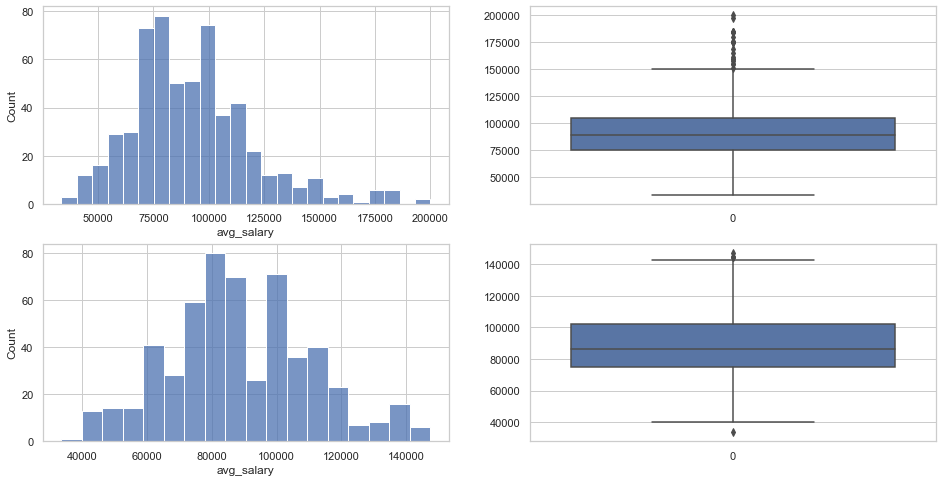

In [86]:
remove_outliers_plot(jobs_dataset, new_jobs_dataset)

In [111]:
# model salary bins for classification labels
def model_bins(bins, df):
    """
    This function plots data value counts for
    different numbers of label classes
    J. Bazarbachian
    Input
    ---------
    df : pandas DataFrame
        DataFrame of jobs
    bins : int
        Number of bins
    Output
    ---------
    Bar charts for [2, bins) label classes
    Example
    -------
    >>> model_bins(8, new_jobs_dataset)
    """
    for i in range(2, bins):
        labels = pd.qcut(df['avg_salary'], q=i)
        counts = labels.value_counts()
        plt.figure()
        counts.plot(kind='bar', grid=True, figsize=(8, 5))

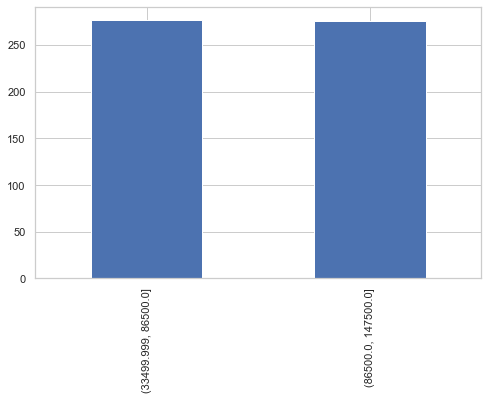

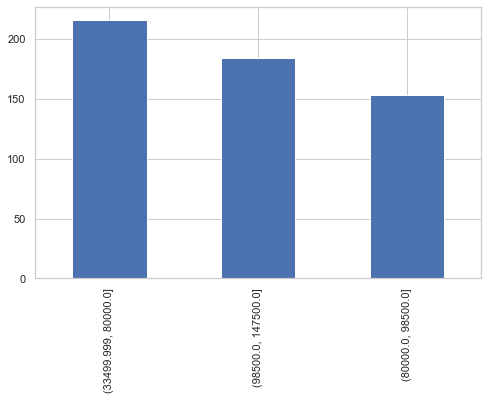

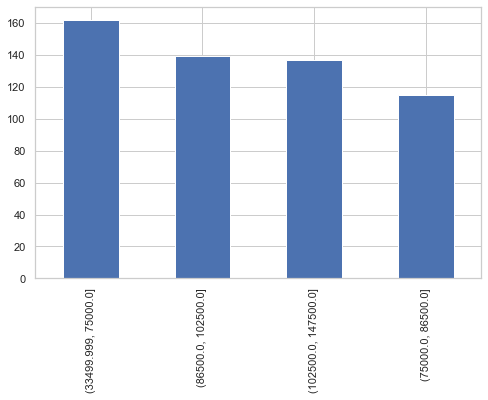

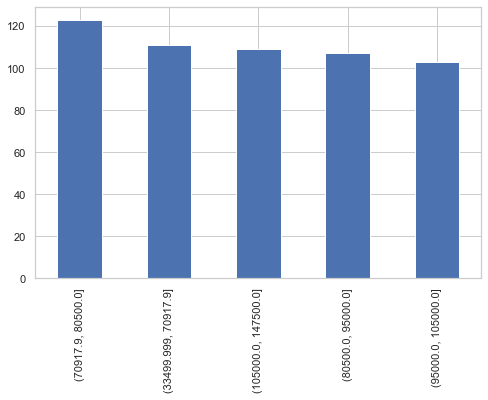

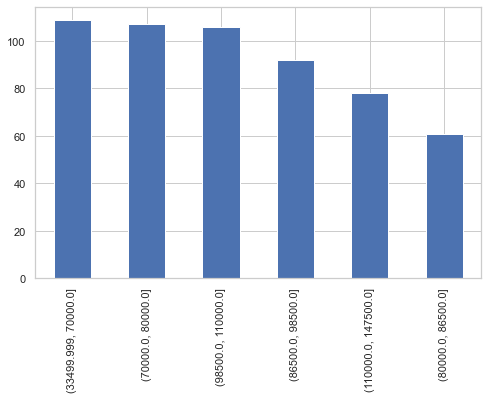

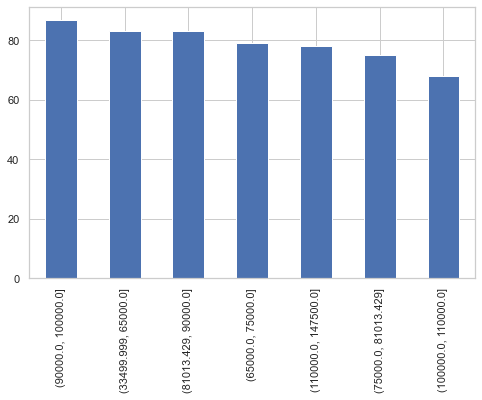

In [134]:
model_bins(8, new_jobs_dataset)

Looking at the bar plots of different numbers of label classes, we can observe that with the data that I've collected, the most balanced number of classes is 2. If I use a larger number of targets with this dataset, I would have a disproportionate number of observations in each class. If I were to use imbalanced label classes in my machine learning models, accuracy would no longer be a very informative performance metric. In addition to having to change performance measures, I would also need to further pre-process the data in order to handle imbalanced classes. For these reasons, we will procede with building binary classification models.

In [113]:
pd.options.mode.chained_assignment = None


def salary_labels(df):
    """
    This function create 2 salary bins for classification labels
    J. Bazarbachian
    Input
    ---------
    df : pandas DataFrame
        DataFrame of jobs
    Output
    ---------
    df : pandas DataFrame with new column 'salary_labels'
        DataFrame of jobs
    Example
    -------
    >>> new_jobs_dataset= salary_labels(new_jobs_dataset)
    >>> print(new_jobs_dataset.shape)
    (553, 9)
    """
    df['salary_labels'] = pd.qcut(df['avg_salary'], q=2)
    return df

In [114]:
new_jobs_dataset = salary_labels(new_jobs_dataset)
print(new_jobs_dataset.shape)

In [115]:
new_jobs_dataset.salary_labels.unique()

[(33499.999, 86500.0], (86500.0, 147500.0]]
Categories (2, interval[float64]): [(33499.999, 86500.0] < (86500.0, 147500.0]]

In [116]:
new_jobs_dataset['salary_labels'].value_counts()

(33499.999, 86500.0]    277
(86500.0, 147500.0]     276
Name: salary_labels, dtype: int64

<div style="border-bottom: 3px solid black;"></div>

### Task 3.2 &mdash; Transforming Job Description data

Before we can vectorize the text data in the job description column, we must first preprocess it by eliminating punctuation and special characters, removing stop words, and applying lemmatization. 

### Please Note: The contents of this next cell are taken from  [NLP Tutorial for Text Classification in Python](https://medium.com/analytics-vidhya/nlp-tutorial-for-text-classification-in-python-8f19cd17b49e)

In [123]:
# for text pre-processing
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer


def preprocess(text):
    """
    This function converts to lowercase, strips and removes punctuations
    V. Rani (https://medium.com/analytics-vidhya/nlp-tutorial-for-text-
                                    classification-in-python-8f19cd17b49e)
    Input
    ---------
    text : String
        Raw text
    Output
    ---------
    text : String
        Text that contain lowercase tokens without punctuations
    Example
    -------
    >>> text = preprocess('Machine LEARNING is gr8 fun!!')
    >>> text
    'machine learning is gr fun'
    """
    text = text.lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

# STOPWORD REMOVAL
def stopword(string):
    """
    This function removes stop words
    V. Rani (https://medium.com/analytics-vidhya/nlp-tutorial-for-text-
                                    classification-in-python-8f19cd17b49e)
    Input
    ---------
    string: String
        Raw text
    Output
    ---------
    text : String
        Text without english and french stop words
    Example
    -------
    >>> text = stopword('you and me toi et moi we learn machine learning')
    >>> text
    'learn machine learning'
    """
    sw_list = stopwords.words('english') + stopwords.words('french')
    a= [i for i in string.split() if i not in sw_list]
    return ' '.join(a)

# LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
def get_wordnet_pos(tag):
    """
    This is a helper function to map NTLK position tags
    V. Rani (https://medium.com/analytics-vidhya/nlp-tutorial-for-text
                                    -classification-in-python-8f19cd17b49e)
    """
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Tokenize the sentence
def lemmatizer(string):
    """
    This function lemmatizes a string
    V. Rani (https://medium.com/analytics-vidhya/nlp-tutorial-for-text
                                    -classification-in-python-8f19cd17b49e)
    Input
    ---------
    string: String
        Raw text
    Output
    ---------
    text : String
        Lemmatized text
    Example
    -------
    >>> text = lemmatizer('fastest machine learning')
    >>> text
    'fast machine learning'
    """
    word_pos_tags = nltk.pos_tag(word_tokenize(string))  # Get position tags
    # Map the position tag and lemmatize the word/token
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] 
    return " ".join(a)


def finalpreprocess(string):
    """
    This function preprocesses text
    V. Rani (https://medium.com/analytics-vidhya/nlp-tutorial-for-text
                                    -classification-in-python-8f19cd17b49e)
    Input
    ---------
    string: String
        Raw text
    Output
    ---------
    string : String
        Preprocessed text
    Example
    -------
    >>> text = finalpreprocess('~Machine learning 4 ever <3')
    >>> text
    'machine learning ever'
    """
    return lemmatizer(stopword(preprocess(string)))


# add clean description column to df
new_jobs_dataset['clean_description'] = new_jobs_dataset['description'].apply(lambda x: finalpreprocess(x))
new_jobs_dataset

,company,positionName,location,description,pay_period,min_salary,max_salary,avg_salary,salary_labels,clean_description
0,Scrawlr Development Inc.,Intermediate Front-End Software Developer,"Montréal, QC",About ScrawlrScrawlr is a company building a s...,yearly,72000.0,89000.0,80500.0,"(33499.999, 86500.0]",scrawlrscrawlr company building software platf...
1,Scrawlr Development Inc.,Senior Front-End Software Developer,"Montréal, QC",About ScrawlrScrawlr is a company building a s...,yearly,85000.0,110000.0,97500.0,"(86500.0, 147500.0]",scrawlrscrawlr company building software platf...
2,LearningBranch Inc.,Senior Machine Learning Engineer,"Montréal, QC",Job Title: Senior Machine Learning EngineerSta...,yearly,65000.0,120000.0,92500.0,"(86500.0, 147500.0]",job title senior machine learn engineerstart d...
3,Scrawlr Development Inc.,Lead Front-End Software Developer,"Montréal, QC",About ScrawlrScrawlr is a company building a s...,yearly,87000.0,120000.0,103500.0,"(86500.0, 147500.0]",scrawlrscrawlr company building software platf...
4,Faimdata,artificial intelligence (ai) programmer,"Montréal, QC",Computer Science\nElectrical and Electronic En...,yearly,85000.0,145000.0,115000.0,"(86500.0, 147500.0]",computer science electrical electronic enginee...
...,...,...,...,...,...,...,...,...,...,...
577,Aarcomm Systems,Electronic Controls Design Engineer,"Coquitlam, BC",Aarcomm Systems is an electronics design and m...,yearly,NaN,NaN,80000.0,"(33499.999, 86500.0]",aarcomm system electronics design manufacturin...
578,Park Place Seniors Living,Network Administrator,"Vancouver, BC",Job Title: Network AdministratorDivision: Info...,yearly,65000.0,85000.0,75000.0,"(33499.999, 86500.0]",job title network administratordivision inform...
579,Johnston Davidson Architecture,Intern Architect / Architectural Technologist,"Vancouver, BC",If you are interested in working as part of a ...,yearly,48000.0,57000.0,52500.0,"(33499.999, 86500.0]",interested work part project team gain valuabl...
580,MTU Maintenance Canada,Programmer Analyst,"Delta, BC",YOUR FUTURE AT MTU STARTS RIGHT HERE!MTU Maint...,yearly,NaN,NaN,80000.0,"(33499.999, 86500.0]",future mtu start right mtu maintenance canada ...


<div style="border-bottom: 3px solid black;"></div>

### Task 3.2.1 &mdash; Bags of words Vectorization

In [124]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# Bag-of-Words Model
count_vect = CountVectorizer()
X_bow = count_vect.fit_transform(new_jobs_dataset.clean_description)
X_train_bow, X_test_bow, y_train_bow, y_test_bow  = train_test_split(X_bow, new_jobs_dataset['salary_labels'].astype('string'), test_size=0.20, random_state=42)

In [125]:
X_train_bow.shape

(442, 13401)

In [126]:
y_train_bow.shape

(442,)

<div style="border-bottom: 3px solid black;"></div>

### Task 3.2.2 &mdash; Term Frequency Vectorization

In [127]:
from sklearn.feature_extraction.text import TfidfTransformer

# Term Frequency model
tf_transformer = TfidfTransformer(use_idf=False).fit(X_bow)
X_tf = tf_transformer.transform(X_bow)
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X_tf, new_jobs_dataset['salary_labels'].astype('string'), test_size=0.20, random_state=42)

In [128]:
X_train_tf.shape

(442, 13401)

In [129]:
y_train_tf.shape

(442,)

<div style="border-bottom: 3px solid black;"></div>

### Task 3.2.3 &mdash; Term Frequency times Inverse Document Frequency Vectorization

In [130]:
# Term Frequency–Inverse Document Frequency model
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_bow)
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, new_jobs_dataset['salary_labels'].astype('string'), test_size=0.20, random_state=42)

In [101]:
X_train_tfidf.shape

(442, 13401)

In [102]:
y_train_tfidf.shape

(442,)

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

# 4. Model Training:

Now that we have encoded the text data in different ways, we are ready to compare their performance with binary classification machine learning models.

<div style="border-bottom: 3px solid black;"></div>

### Task 4.1 &mdash; Naive Bayes Classifier

In [211]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score


X_train, X_test, y_train, y_test = train_test_split(new_jobs_dataset['clean_description'], new_jobs_dataset['salary_labels'].astype('string'), test_size=0.20, random_state=42)
# BOW Features + Naive Bayes Classifier
nb_bow = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB()),
])

nb_tf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer(use_idf=False)),
    ('clf', MultinomialNB()),
])

nb_tfidf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer(use_idf=True)),
    ('clf', MultinomialNB()),
])

parameters = {'vect__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 3), (3, 4)],
              'vect__max_features': (50, 100, 500, 1000, 5000, 10000, 15000, 20000, None),
              'clf__alpha': (1.0, 1e-2, 1e-3)}

def performance(model):
    """
    This function prints perfomance metrics for our classification models
    J. Bazarbachian
    Input
    ---------
    model : Pipeline object
        Pipeline of estimators
    Output
    ---------
    score : float
        accuracy of model
    scores : float
        cross validation scores
    classification_report : float
        metrics: precision, recall, f-1 score, support    
    plot_confusion_matrix : plot
        plot of confusion matrix        
    Example
    -------
    >>> performance(nb_bow)
    Accuracy score: 66.67%
    Cross-validated scores: [0.6741573  0.73033708 0.64772727 0.68181818 0.69318182]
                          precision    recall  f1-score   support

    (33499.999, 86500.0]       0.62      0.79      0.69        53
     (86500.0, 147500.0]       0.74      0.55      0.63        58

                accuracy                           0.67       111
               macro avg       0.68      0.67      0.66       111
            weighted avg       0.68      0.67      0.66       111

    """
    model = model.fit(X_train, y_train)
    y_pred  = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    print("Accuracy score: %0.1f%%" %(score*100))
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print("Cross-validated scores:", scores)
    #printing classification report
    target_names = model.classes_
    print(classification_report(y_test, y_pred, target_names=target_names))
    sns.set_theme(style="white")
    disp = plot_confusion_matrix(model, X_test, y_test,
                                 display_labels=target_names,
                                 cmap=plt.cm.Blues,
                                 normalize=None)
    disp.ax_.set_title("BOW Features + Naive Bayes Classifier")

Accuracy score: 66.7%
Cross-validated scores: [0.6741573  0.73033708 0.64772727 0.68181818 0.69318182]
                      precision    recall  f1-score   support

(33499.999, 86500.0]       0.62      0.79      0.69        53
 (86500.0, 147500.0]       0.74      0.55      0.63        58

            accuracy                           0.67       111
           macro avg       0.68      0.67      0.66       111
        weighted avg       0.68      0.67      0.66       111



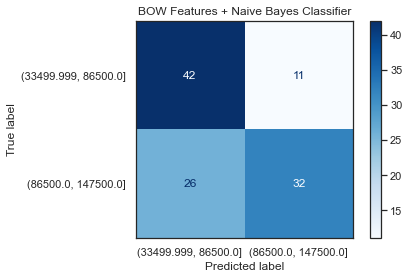

In [212]:
# BOW Features + Naive Bayes Classifier
performance(nb_bow)

Accuracy score: 65.8%
Cross-validated scores: [0.6741573  0.75280899 0.64772727 0.65909091 0.73863636]
                      precision    recall  f1-score   support

(33499.999, 86500.0]       0.62      0.74      0.67        53
 (86500.0, 147500.0]       0.71      0.59      0.64        58

            accuracy                           0.66       111
           macro avg       0.66      0.66      0.66       111
        weighted avg       0.67      0.66      0.66       111



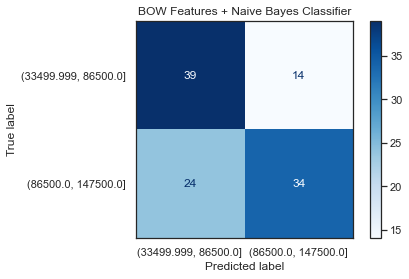

In [213]:
# Tf Features + Naive Bayes Classifier
performance(nb_tf)

Accuracy score: 68.5%
Cross-validated scores: [0.6741573  0.73033708 0.65909091 0.69318182 0.75      ]
                      precision    recall  f1-score   support

(33499.999, 86500.0]       0.65      0.74      0.69        53
 (86500.0, 147500.0]       0.73      0.64      0.68        58

            accuracy                           0.68       111
           macro avg       0.69      0.69      0.68       111
        weighted avg       0.69      0.68      0.68       111



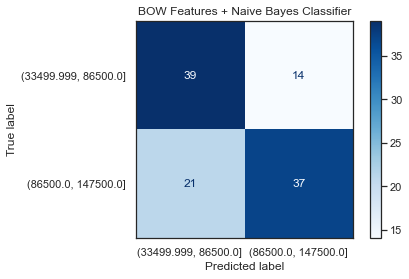

In [214]:
# Tf-idf Features + Naive Bayes Classifier
performance(nb_tfidf)

<div style="border-bottom: 3px solid black;"></div>

### Task 4.2 &mdash; Linear Support Vector Machine Classifier

In [238]:
from sklearn.linear_model import SGDClassifier

# BOW Features + SGD Classifier
sgd_bow = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', SGDClassifier(random_state=42)),
])

sgd_tf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer(use_idf=False)),
    ('clf', SGDClassifier(random_state=42)),
])

sgd_tfidf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer(use_idf=True)),
    ('clf', SGDClassifier(random_state=42)),
])

parameters = {'vect__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 3), (3, 4)],
              'clf__loss': ('hinge', 'perceptron'), 
              'clf__penalty': ('l1', 'l2', None),
              'clf__eta0': [1.0],
              'clf__learning_rate': ['constant', 'optimal'],
              'clf__alpha': (1e-3, 1e-4),
              'clf__max_iter': [100]}

Accuracy score: 70.3%
Cross-validated scores: [0.62921348 0.73033708 0.71590909 0.80681818 0.73863636]
                      precision    recall  f1-score   support

(33499.999, 86500.0]       0.64      0.87      0.74        53
 (86500.0, 147500.0]       0.82      0.55      0.66        58

            accuracy                           0.70       111
           macro avg       0.73      0.71      0.70       111
        weighted avg       0.73      0.70      0.70       111



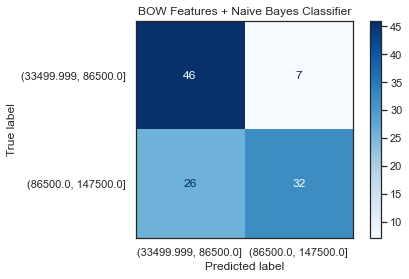

In [218]:
# BOW Features + SGD Classifier
performance(sgd_bow)

Accuracy score: 71.2%
Cross-validated scores: [0.71910112 0.7752809  0.65909091 0.78409091 0.73863636]
                      precision    recall  f1-score   support

(33499.999, 86500.0]       0.66      0.83      0.73        53
 (86500.0, 147500.0]       0.80      0.60      0.69        58

            accuracy                           0.71       111
           macro avg       0.73      0.72      0.71       111
        weighted avg       0.73      0.71      0.71       111



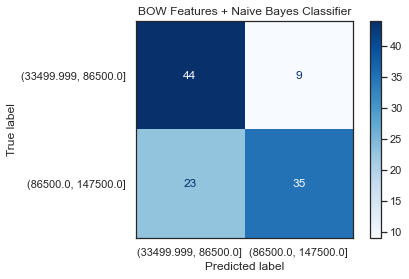

In [219]:
# Tf Features + SGD Classifier
performance(sgd_tf)

Accuracy score: 74.8%
Cross-validated scores: [0.7752809  0.79775281 0.72727273 0.77272727 0.78409091]
                      precision    recall  f1-score   support

(33499.999, 86500.0]       0.70      0.81      0.75        53
 (86500.0, 147500.0]       0.80      0.69      0.74        58

            accuracy                           0.75       111
           macro avg       0.75      0.75      0.75       111
        weighted avg       0.75      0.75      0.75       111



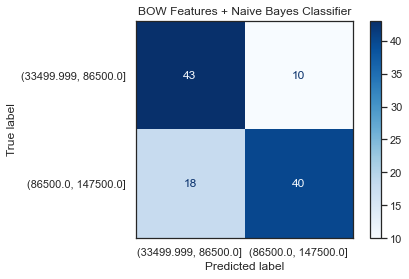

In [220]:
# Tf-idf Features + SGD Classifier
performance(sgd_tfidf)

<div style="border-bottom: 3px solid black;"></div>

### Task 4.3 &mdash; Logistic Regression Classifier

In [254]:
from sklearn.linear_model import LogisticRegression

log_bow = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', LogisticRegression(n_jobs=-1)),
])

log_tf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer(use_idf=False)),
    ('clf', LogisticRegression(n_jobs=-1)),
])

log_tfidf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer(use_idf=True)),
    ('clf', LogisticRegression(n_jobs=-1)),
])

parameters = {'vect__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 3), (3, 4)],
              'clf__C': (1e5, 1e4, 1e3)}

Accuracy score: 70.3%
Cross-validated scores: [0.73033708 0.83146067 0.69318182 0.80681818 0.76136364]
                      precision    recall  f1-score   support

(33499.999, 86500.0]       0.65      0.83      0.73        53
 (86500.0, 147500.0]       0.79      0.59      0.67        58

            accuracy                           0.70       111
           macro avg       0.72      0.71      0.70       111
        weighted avg       0.72      0.70      0.70       111



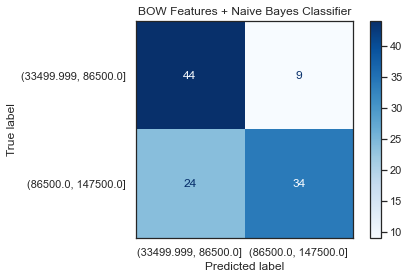

In [255]:
# BOW Features + Logistic Regression Classifier
performance(log_bow)

Accuracy score: 66.7%
Cross-validated scores: [0.68539326 0.75280899 0.625      0.70454545 0.76136364]
                      precision    recall  f1-score   support

(33499.999, 86500.0]       0.61      0.83      0.70        53
 (86500.0, 147500.0]       0.77      0.52      0.62        58

            accuracy                           0.67       111
           macro avg       0.69      0.67      0.66       111
        weighted avg       0.69      0.67      0.66       111



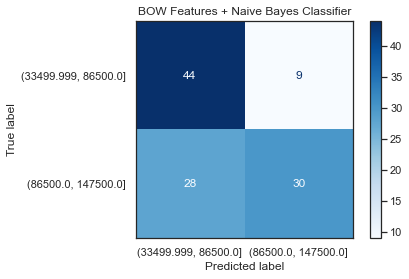

In [256]:
# Tf Features + Logistic Regression Classifier
performance(log_tf)

Accuracy score: 67.6%
Cross-validated scores: [0.69662921 0.80898876 0.65909091 0.71590909 0.76136364]
                      precision    recall  f1-score   support

(33499.999, 86500.0]       0.62      0.83      0.71        53
 (86500.0, 147500.0]       0.78      0.53      0.63        58

            accuracy                           0.68       111
           macro avg       0.70      0.68      0.67       111
        weighted avg       0.70      0.68      0.67       111



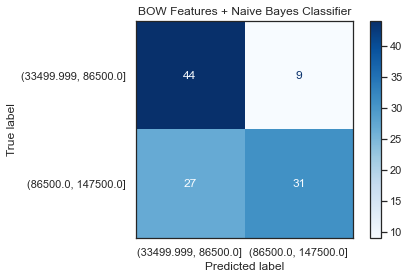

In [245]:
# Tf-idf Features + Logistic Regression Classifier
performance(log_tfidf)

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

# 5. Hyperparameter Tuning:

In [206]:
from sklearn.model_selection import GridSearchCV

def gridsearch(model):
    """
    This function performs GridSearch for our classification models
    J. Bazarbachian
    Input
    ---------
    model : Pipeline object
        Pipeline of estimators
    Output
    ---------
    gridcv.best_params_ : float
        accuracy of model
    grid_accuracy_train : float
        training set accuracy scores
    grid_accuracy_test : float
        test set accuracy scores            
    Example
    -------
    >>> gridsearch(nb_bow)
    Parameter setting that gave the best results on the hold out data:
    {'clf__alpha': 0.001, 'vect__max_features': None, 'vect__ngram_range': (2, 3)}
    Grid search accuracy:
     99.1% train accuracy
     76.6% test accuracy
    """
    gridcv = GridSearchCV(model, parameters, n_jobs=-1)
    gridcv = gridcv.fit(X_train, y_train)
    print('Parameter setting that gave the best results on the hold out data:')
    print(gridcv.best_params_)
    grid_accuracy_train = gridcv.best_estimator_.score(X_train, y_train)
    grid_accuracy_test  = gridcv.best_estimator_.score(X_test, y_test)
    print("Grid search accuracy:")
    print(" %.1f%% train accuracy" % (grid_accuracy_train*100))
    print(" %.1f%% test accuracy" % (grid_accuracy_test*100))

In [208]:
# BOW Features + Naive Bayes Classifier
gridsearch(nb_bow)

Parameter setting that gave the best results on the hold out data:
{'clf__alpha': 0.001, 'vect__max_features': None, 'vect__ngram_range': (2, 3)}
Grid search accuracy:
 99.1% train accuracy
 76.6% test accuracy


In [209]:
# Tf Features + Naive Bayes Classifier
gridsearch(nb_tf)

Parameter setting that gave the best results on the hold out data:
{'clf__alpha': 0.001, 'vect__max_features': None, 'vect__ngram_range': (1, 2)}
Grid search accuracy:
 96.4% train accuracy
 73.0% test accuracy


In [210]:
# Tf-idf Features + Naive Bayes Classifier
gridsearch(nb_tfidf)

Parameter setting that gave the best results on the hold out data:
{'clf__alpha': 0.001, 'vect__max_features': None, 'vect__ngram_range': (3, 3)}
Grid search accuracy:
 99.8% train accuracy
 71.2% test accuracy


In [239]:
# BOW Features + SGD Classifier
gridsearch(sgd_bow)

Parameter setting that gave the best results on the hold out data:
{'clf__alpha': 0.001, 'clf__eta0': 1.0, 'clf__learning_rate': 'constant', 'clf__loss': 'perceptron', 'clf__max_iter': 100, 'clf__penalty': None, 'vect__ngram_range': (1, 1)}
Grid search accuracy:
 98.9% train accuracy
 76.6% test accuracy


In [240]:
# Tf Features + SGD Classifier
gridsearch(sgd_tf)

Parameter setting that gave the best results on the hold out data:
{'clf__alpha': 0.0001, 'clf__eta0': 1.0, 'clf__learning_rate': 'optimal', 'clf__loss': 'hinge', 'clf__max_iter': 100, 'clf__penalty': None, 'vect__ngram_range': (1, 1)}
Grid search accuracy:
 99.8% train accuracy
 72.1% test accuracy


In [241]:
# Tf-idf Features + SGD Classifier
gridsearch(sgd_tfidf)

Parameter setting that gave the best results on the hold out data:
{'clf__alpha': 0.001, 'clf__eta0': 1.0, 'clf__learning_rate': 'constant', 'clf__loss': 'hinge', 'clf__max_iter': 100, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 2)}
Grid search accuracy:
 99.5% train accuracy
 73.0% test accuracy


In [247]:
# BOW Features + Logistic Regression Classifier
gridsearch(log_bow)

Parameter setting that gave the best results on the hold out data:
{'clf__C': 10000.0, 'vect__ngram_range': (1, 2)}
Grid search accuracy:
 99.8% train accuracy
 70.3% test accuracy


In [248]:
# Tf Features + Logistic Regression Classifier
gridsearch(log_tf)

Parameter setting that gave the best results on the hold out data:
{'clf__C': 100000.0, 'vect__ngram_range': (1, 2)}
Grid search accuracy:
 99.8% train accuracy
 73.9% test accuracy


In [249]:
# Tf-idf Features + Logistic Regression Classifier
gridsearch(log_tfidf)

Parameter setting that gave the best results on the hold out data:
{'clf__C': 100000.0, 'vect__ngram_range': (1, 1)}
Grid search accuracy:
 99.8% train accuracy
 73.9% test accuracy


In [122]:
%pycodestyle_off